In [10]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import itertools
import os
import glob
from scipy import stats
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

## Tie data from multiple h5 files

In [11]:
foldername = '0066'
start_frame = 200    # this is the number of frames dropped at the start and end due to the cross correlation window

In [12]:
names = sorted(glob.glob('/media/user/Samsung_T3/Work/Documents/Data/MGrobisData/10-fish/' + foldername + '/' + foldername + '_0*.h5'))

In [13]:
i=0
for name in names:
    f = h5py.File(name, "r")
    group = f['fields/']
    
    n_inds = 10

    vid_id = np.repeat(i, (group['x'].value).shape[0]*(group['x'].value).shape[1]*(group['x'].value).shape[0]).reshape((1,-1))
    frame = (np.repeat(np.tile(np.arange((group['x'].value).shape[1]), n_inds).reshape((1,-1)), n_inds)).reshape((1,-1))
    pos_x = (np.repeat((group['x'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    pos_y = (np.repeat((group['y'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    ang_area_left = (group['ang_area_left_eye'].value).reshape((1,-1))
    ang_area_right = (group['ang_area_right_eye'].value).reshape((1,-1))
    ang_pos_left = (group['ang_com_left_eye'].value).reshape((1,-1))
    ang_pos_right = (group['ang_com_right_eye'].value).reshape((1,-1))
    
    tmp = np.squeeze(np.array([vid_id, frame, pos_x, pos_y, ang_area_left, ang_area_right, ang_pos_left, ang_pos_right])).T
    if i != 0:
        tmp_curr = pd.DataFrame(tmp, columns=['vid_id', 'frame', 'pos_x', 'pos_y', 'ang_area_left_eye', 'ang_area_right_eye', 'ang_pos_left_eye', 'ang_pos_right_eye'])
        tmp_min = tmp_curr[tmp_curr['frame'] == 0]
        tmp_min = tmp_min.drop_duplicates(subset='pos_x', keep="last")
        tmp_max = tmp_prev[tmp_prev['frame'] == max(tmp_prev['frame'])]
        tmp_max = tmp_max.drop_duplicates(subset='pos_x', keep="last")
        
        last = list(np.array([tmp_max['pos_x'],tmp_max['pos_y']]).T)
        this = list(np.array([tmp_min['pos_x'],tmp_min['pos_y']]).T)
        
        cost = cdist(this,last)
        orig_ids, new_idx = linear_sum_assignment(cost)
        new_ids = tmp_max['f_id'].values[new_idx]
        
        tmp_curr['f_id'] = np.repeat(new_ids, (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        tmp_curr['n_id'] = np.tile(new_ids, (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        df = pd.concat([df,tmp_curr])
        tmp_prev = tmp_curr
    else:
        fid = np.repeat(np.arange(n_inds), (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        nid = np.tile(np.arange(n_inds), (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        data = np.hstack((tmp,fid, nid))
        df = pd.DataFrame(data, columns=['vid_id', 'frame', 'pos_x', 'pos_y', 'ang_area_left_eye', 'ang_area_right_eye', 'ang_pos_left_eye', 'ang_pos_right_eye', 'f_id', 'n_id'])
        tmp_prev = df
    
    i = i+1

print(df.shape[0] - df.dropna().shape[0]) # print number of rows with nas (thish should be 0)

0


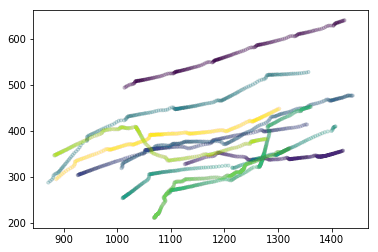

In [14]:
import matplotlib.pyplot as plt

df_plot = df[(df['frame'] < 200) & (df['vid_id'] == 0)]

plt.scatter(df_plot['pos_x'], df_plot['pos_y'], c=df_plot['f_id'].values, s=10, alpha=0.02)
plt.show()

In [15]:
for i in np.unique(df['vid_id']):
    if i != 0:
        df.iloc[np.where(df['vid_id'] == i)[0],1] += (max(df[df['vid_id'] == i-1]['frame']) + 1)
        
df = df[(df['frame'] >= start_frame) & (df['frame'] <= max(df['frame']) - start_frame)]
df = df[df['f_id'] != df['n_id']]
df.head()

,vid_id,frame,pos_x,pos_y,ang_area_left_eye,ang_area_right_eye,ang_pos_left_eye,ang_pos_right_eye,f_id,n_id
2001,0.0,200.0,1011.162553,491.923601,0.0,0.333009,0.0,2.948385,0.0,1.0
2002,0.0,200.0,1011.162553,491.923601,0.0,0.329867,0.0,-1.253495,0.0,2.0
2003,0.0,200.0,1011.162553,491.923601,0.0,0.339292,0.0,-2.037323,0.0,3.0
2004,0.0,200.0,1011.162553,491.923601,0.0,0.056549,0.0,-0.755553,0.0,4.0
2005,0.0,200.0,1011.162553,491.923601,0.0,0.000000,0.0,0.000000,0.0,5.0


In [16]:
dcorr = pd.read_csv("/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Data/Output/golden_shiners/10_fish/" + foldername + '/cross_correlation.csv')
dcorr.columns = ['frame', 'f_id', 'n_id', 'tau', 'cc']

dcorr.iloc[np.where(dcorr['cc'] < np.sqrt(3)/2)[0],4] = 0
dcorr.iloc[np.where(np.abs(dcorr['tau']) <= 5)[0],3] = 0

for fr in np.unique(dcorr['frame']):
    for idx in np.unique(dcorr['f_id']):
        subset_idxs = np.where((dcorr['frame'] == fr) & (dcorr['f_id'] == idx) & (dcorr['tau'] < 0))[0]
        if len(subset_idxs) > 0:
            ccvals = dcorr.iloc[subset_idxs]['cc']
            if max(ccvals > np.sqrt(3)/2):
                max_idx = subset_idxs[np.where(ccvals == max(ccvals))[0]]
                dcorr.iloc[max_idx,4] = 1
    if fr % 1000 == 0:
        print(fr)

dcorr.iloc[np.where(dcorr['cc'] != 1)[0],4] = 0

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [17]:
df = pd.merge(df, dcorr)

cols = ['frame', 'f_id', 'n_id']
df[cols] = df[cols].astype(np.int32)

df['cos_pos_left_eye'] = np.cos(df['ang_pos_left_eye'])
df['sin_pos_left_eye'] = np.sin(df['ang_pos_left_eye'])
df['cos_pos_right_eye'] = np.cos(df['ang_pos_right_eye'])
df['sin_pos_right_eye'] = np.sin(df['ang_pos_right_eye'])
df['ang_area_left_eye'] = df['ang_area_left_eye'] / np.pi - 1
df['ang_area_right_eye'] = df['ang_area_right_eye'] / np.pi - 1
df['leader'] = df['cc']

cols = ['vid_id', 'pos_x', 'pos_y', 'ang_pos_left_eye', 'ang_pos_right_eye', 'cc', 'tau']
df = df.drop(cols, axis=1)
df.head()

,frame,ang_area_left_eye,ang_area_right_eye,f_id,n_id,cos_pos_left_eye,sin_pos_left_eye,cos_pos_right_eye,sin_pos_right_eye,leader
0,200,-1.0,-0.894,0,1,1.0,0.0,-0.981393,0.192008,0.0
1,200,-1.0,-0.895,0,2,1.0,0.0,0.312003,-0.950081,0.0
2,200,-1.0,-0.892,0,3,1.0,0.0,-0.449787,-0.893136,0.0
3,200,-1.0,-0.982,0,4,1.0,0.0,0.727892,-0.685691,0.0
4,200,-1.0,-1.000,0,5,1.0,0.0,1.000000,0.000000,0.0


In [18]:
df.to_hdf('/mnt/ssd1/Documents/Vivek/dnn/vision_leadership/golden_shiners/10_fish/' + foldername + '/' + foldername + '.h5', key='df', mode='w')